In [1]:
import time
import numpy as np
import pandas as pd
import os
import sys
import sklearn
import datetime
import random
import matplotlib.pyplot as plt
import math
import tensorflow as tf

from tensorflow.keras import Model, models,layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Activation, Flatten, BatchNormalization, GlobalAveragePooling2D, GlobalMaxPooling2D
from tensorflow.keras.backend import batch_normalization
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import metrics
from packaging import version

import pydicom
from pydicom.data import get_testdata_files
%matplotlib inline

from tqdm import tqdm

Using TensorFlow backend.


In [2]:
print("TensorFlow version: ", tf.__version__)

TensorFlow version:  2.2.0


In [3]:
# read csvs
calc_train = pd.read_csv("calc_case_description_train_set.csv")
mass_train = pd.read_csv("mass_case_description_train_set.csv")
calc_test = pd.read_csv("calc_case_description_test_set.csv")
mass_test = pd.read_csv("mass_case_description_test_set.csv")

In [4]:
# Added new image paths
calc_train['images_path'] = 'CBIS-DDSM/train/Calc_All_DICOM/' + calc_train['cropped image file path'].str.split('/').str[0].str[14:-1] + '_' + calc_train['cropped image file path'].str.split('/').str[0].str[-1] + '_11' + '.dcm'
calc_train.drop(["image file path","cropped image file path","ROI mask file path"], axis=1, inplace=True)

calc_test['images_path'] = 'CBIS-DDSM/test/Calc_All_DICOM/' + calc_test['cropped image file path'].str.split('/').str[0].str[10:-1] + '_' + calc_test['cropped image file path'].str.split('/').str[0].str[-1] + '_11' + '.dcm'
calc_test.drop(["image file path","cropped image file path","ROI mask file path"], axis=1, inplace=True)

mass_train['images_path'] = 'CBIS-DDSM/train/Mass_All_DICOM/' + mass_train['cropped image file path'].str.split('/').str[0].str[14:-1] + '_' + mass_train['cropped image file path'].str.split('/').str[0].str[-1] + '_11' + '.dcm'
mass_train.drop(["image file path","cropped image file path","ROI mask file path"], axis=1, inplace=True)

mass_test['images_path'] = 'CBIS-DDSM/test/Mass_All_DICOM/' + mass_test['cropped image file path'].str.split('/').str[0].str[10:-1] + '_' + mass_test['cropped image file path'].str.split('/').str[0].str[-1] + '_11' + '.dcm'
mass_test.drop(["image file path","cropped image file path","ROI mask file path"], axis=1, inplace=True)


In [5]:
mass_train.head()

,patient_id,breast_density,left or right breast,image view,abnormality id,abnormality type,mass shape,mass margins,assessment,pathology,subtlety,images_path
0,P_00001,3,LEFT,CC,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,CBIS-DDSM/train/Mass_All_DICOM/P_00001_LEFT_CC...
1,P_00001,3,LEFT,MLO,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,CBIS-DDSM/train/Mass_All_DICOM/P_00001_LEFT_ML...
2,P_00004,3,LEFT,CC,1,mass,ARCHITECTURAL_DISTORTION,ILL_DEFINED,4,BENIGN,3,CBIS-DDSM/train/Mass_All_DICOM/P_00004_LEFT_CC...
3,P_00004,3,LEFT,MLO,1,mass,ARCHITECTURAL_DISTORTION,ILL_DEFINED,4,BENIGN,3,CBIS-DDSM/train/Mass_All_DICOM/P_00004_LEFT_ML...
4,P_00004,3,RIGHT,MLO,1,mass,OVAL,CIRCUMSCRIBED,4,BENIGN,5,CBIS-DDSM/train/Mass_All_DICOM/P_00004_RIGHT_M...


In [6]:
df_test = pd.concat([mass_test[['pathology','images_path','abnormality type']],calc_test[['pathology','images_path','abnormality type']]])
df_train = pd.concat([mass_train[['pathology','images_path','abnormality type']],calc_train[['pathology','images_path','abnormality type']]])

In [7]:
# remove mass because of image name issue
df_train = calc_train[['pathology','images_path','abnormality type']]
df_test = calc_test[['pathology','images_path','abnormality type']]

In [8]:
df_train

,pathology,images_path,abnormality type
0,MALIGNANT,CBIS-DDSM/train/Calc_All_DICOM/P_00005_RIGHT_C...,calcification
1,MALIGNANT,CBIS-DDSM/train/Calc_All_DICOM/P_00005_RIGHT_M...,calcification
2,BENIGN,CBIS-DDSM/train/Calc_All_DICOM/P_00007_LEFT_CC...,calcification
3,BENIGN,CBIS-DDSM/train/Calc_All_DICOM/P_00007_LEFT_ML...,calcification
4,BENIGN_WITHOUT_CALLBACK,CBIS-DDSM/train/Calc_All_DICOM/P_00008_LEFT_CC...,calcification
...,...,...,...
1541,MALIGNANT,CBIS-DDSM/train/Calc_All_DICOM/P_02566_RIGHT_M...,calcification
1542,MALIGNANT,CBIS-DDSM/train/Calc_All_DICOM/P_02572_LEFT_CC...,calcification
1543,MALIGNANT,CBIS-DDSM/train/Calc_All_DICOM/P_02572_LEFT_ML...,calcification
1544,BENIGN,CBIS-DDSM/train/Calc_All_DICOM/P_02584_LEFT_CC...,calcification


In [9]:
df_train.images_path[0]

'CBIS-DDSM/train/Calc_All_DICOM/P_00005_RIGHT_CC__1_11.dcm'

In [10]:
# remove benign without callback
df_test = df_test[df_test['pathology']!='BENIGN_WITHOUT_CALLBACK']
df_train = df_train[df_train['pathology']!='BENIGN_WITHOUT_CALLBACK']

In [11]:
# conbination
df_train['label'] = df_train['pathology'] + ' ' + df_train['abnormality type']
df_test['label'] = df_test['pathology'] + ' ' + df_test['abnormality type']

G:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [12]:
df_test['label'][:20]

0        BENIGN calcification
1        BENIGN calcification
14       BENIGN calcification
15       BENIGN calcification
16    MALIGNANT calcification
17    MALIGNANT calcification
18       BENIGN calcification
27       BENIGN calcification
28       BENIGN calcification
29    MALIGNANT calcification
30       BENIGN calcification
31       BENIGN calcification
32    MALIGNANT calcification
33       BENIGN calcification
34       BENIGN calcification
35       BENIGN calcification
36       BENIGN calcification
37    MALIGNANT calcification
38    MALIGNANT calcification
44       BENIGN calcification
Name: label, dtype: object

In [13]:
# final train set
df_train

,pathology,images_path,abnormality type,label
0,MALIGNANT,CBIS-DDSM/train/Calc_All_DICOM/P_00005_RIGHT_C...,calcification,MALIGNANT calcification
1,MALIGNANT,CBIS-DDSM/train/Calc_All_DICOM/P_00005_RIGHT_M...,calcification,MALIGNANT calcification
2,BENIGN,CBIS-DDSM/train/Calc_All_DICOM/P_00007_LEFT_CC...,calcification,BENIGN calcification
3,BENIGN,CBIS-DDSM/train/Calc_All_DICOM/P_00007_LEFT_ML...,calcification,BENIGN calcification
22,BENIGN,CBIS-DDSM/train/Calc_All_DICOM/P_00011_LEFT_CC...,calcification,BENIGN calcification
...,...,...,...,...
1541,MALIGNANT,CBIS-DDSM/train/Calc_All_DICOM/P_02566_RIGHT_M...,calcification,MALIGNANT calcification
1542,MALIGNANT,CBIS-DDSM/train/Calc_All_DICOM/P_02572_LEFT_CC...,calcification,MALIGNANT calcification
1543,MALIGNANT,CBIS-DDSM/train/Calc_All_DICOM/P_02572_LEFT_ML...,calcification,MALIGNANT calcification
1544,BENIGN,CBIS-DDSM/train/Calc_All_DICOM/P_02584_LEFT_CC...,calcification,BENIGN calcification


In [29]:
# original images with their labels
train_arr = []
train_label = []

# calculate mean size
mean_width = 0
mean_height = 0
for img_path in tqdm(df_train['images_path']):
    img = pydicom.dcmread(img_path).pixel_array
    IMG_PX_SIZE = 256
    mean_width += img.shape[0]
    mean_height += img.shape[1]

    train_arr.append(img)
for label in df_train['label']:
    if label=='BENIGN calcification':
        train_label.append(0)
    else:
        train_label.append(1)
mean_width = mean_width/len(df_train['images_path'])
mean_height = mean_height/len(df_train['images_path'])

100%|██████████| 1072/1072 [00:01<00:00, 603.64it/s]


In [30]:
(mean_width, mean_height)

(542.3460820895523, 543.1865671641791)

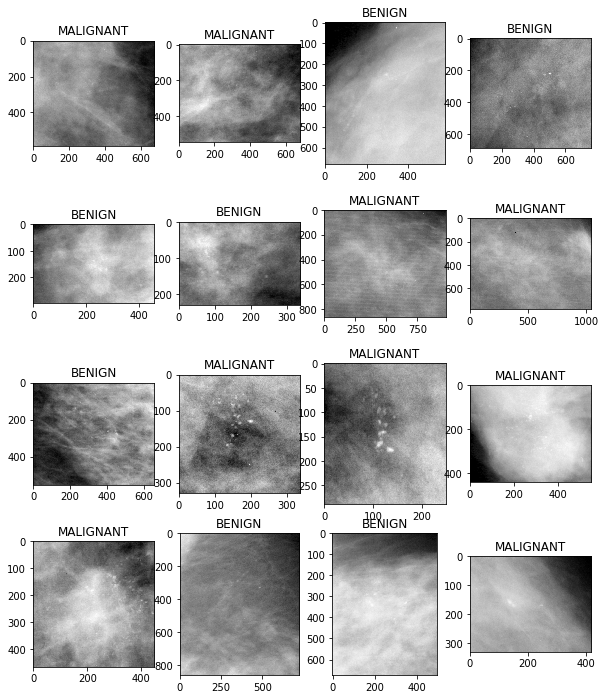

In [32]:
# display original sample images
fig, m_axs = plt.subplots(4, 4, figsize = (10, 12))
num = 0
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(train_arr[i],cmap='gray')
    plt.title('BENIGN'if train_label[i] == 0 else "MALIGNANT")
plt.show()

In [19]:
# resize images and labeling
def create_train_test(df):
    x_arr = []
    y_arr = []
    for img_path in tqdm(df['images_path']):
        img = pydicom.dcmread(img_path).pixel_array
        # 256 * 256 pixels
        IMG_PX_SIZE = 256
        # resize to new size
        resized_img = resize(img, (IMG_PX_SIZE, IMG_PX_SIZE), anti_aliasing=True)
        
        img_2d = resized_img.astype(float)
        img_2d_scaled = (np.maximum(img_2d,0) / img_2d.max()) * 255.0
        img_2d_scaled = np.uint8(img_2d_scaled)
        
        x_arr.append(img_2d_scaled)
        
    for label in df['label']:
        if label=='BENIGN calcification':
            y_arr.append(0)
        else:
            y_arr.append(1)
        
    return np.asarray(x_arr), np.asarray(y_arr)

In [20]:
x_train, y_train = create_train_test(df_train)

100%|██████████| 1072/1072 [00:22<00:00, 48.26it/s]


In [21]:
x_test, y_test = create_train_test(df_test)

100%|██████████| 259/259 [00:15<00:00, 16.72it/s]


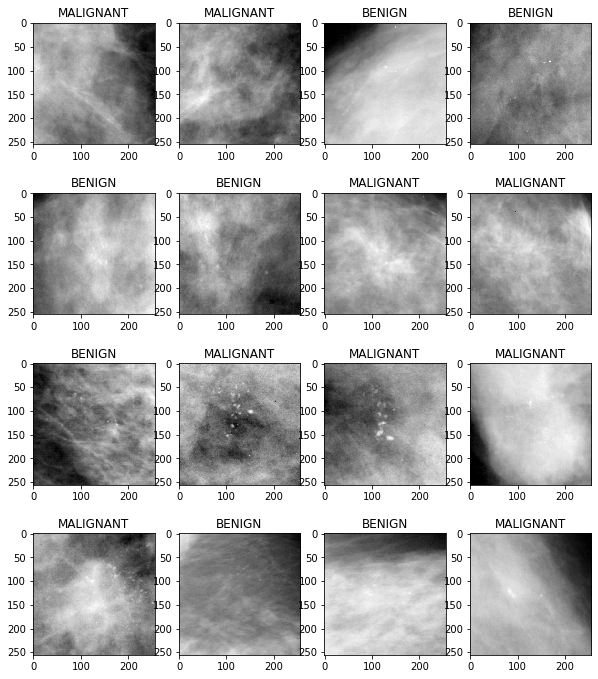

In [27]:
# display resized images
fig, m_axs = plt.subplots(4, 4, figsize = (10, 12))
num = 0
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(x_train[i],cmap='gray')
    plt.title('BENIGN'if y_train[i] == 0 else "MALIGNANT")
plt.show()

In [33]:
# normalization
x_train = x_train/255
x_test = x_test/255

In [34]:
# reshape for CNN feed
X_train = x_train.reshape(x_train.shape[0], 256, 256, 1)
X_test= x_test.reshape(x_test.shape[0],256,256,1)

In [35]:
# label
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [36]:
classes = 2

# build CNN model
def define_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=X_train.shape[1:]))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(classes, activation='sigmoid'))
    # compile model
    opt = Adam(lr=0.001, beta_1=0.9, beta_2 = 0.999)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [37]:
model = define_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 32)      320       
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 256, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 32)      9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 256, 256, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 128, 128, 32)      0         
_________________________________________________________________
flatten (Flatten)            (None, 524288)            0

In [35]:
# set early stopping to avoid further overfitting and save time
early_stopping=tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0,
                              patience=2, verbose=0, mode='auto',
                              baseline=None, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=50, batch_size=5,validation_data=(X_test, y_test),callbacks = [early_stopping])

Epoch 1/50
215/215 [==============================] - 229s 1s/step - loss: 0.7869 - accuracy: 0.5392 - val_loss: 0.7408 - val_accuracy: 0.5097
Epoch 2/50
215/215 [==============================] - 228s 1s/step - loss: 0.7377 - accuracy: 0.5504 - val_loss: 0.7178 - val_accuracy: 0.5290
Epoch 3/50
215/215 [==============================] - 210s 977ms/step - loss: 0.7286 - accuracy: 0.5569 - val_loss: 0.6800 - val_accuracy: 0.5598
Epoch 4/50
215/215 [==============================] - 204s 950ms/step - loss: 0.7234 - accuracy: 0.5541 - val_loss: 0.6940 - val_accuracy: 0.5753
Epoch 5/50
215/215 [==============================] - 209s 971ms/step - loss: 0.7162 - accuracy: 0.5504 - val_loss: 0.6774 - val_accuracy: 0.5637
Epoch 6/50
215/215 [==============================] - 206s 958ms/step - loss: 0.7032 - accuracy: 0.5672 - val_loss: 0.8051 - val_accuracy: 0.4903
Epoch 7/50
215/215 [==============================] - 205s 953ms/step - loss: 0.6906 - accuracy: 0.5858 - val_loss: 0.6987 - val_a

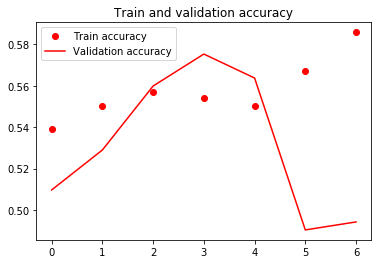

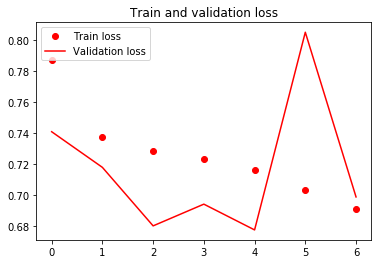

In [36]:
import matplotlib.pyplot as plt
%matplotlib inline

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'ro', label='Train accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.title('Train and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'ro', label='Train loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Train and validation loss')
plt.legend()
plt.show()